# RNN-Autoencoder

Попытка использовать большое количество оригиналов для обучения без учителя. С этой целью используется модель автоэнкодера с RNN энкодером и декодером. В качестве входных данных эмбеддинги, полученные с помощью ResNet 34.

Гипотеза: При реконструкции атак ошибка должна быть выше (аномалии).

## Dependences

In [1]:
!nvidia-smi

Wed Apr 28 22:39:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ffmpeg-python

In [3]:
import os
import cv2
import ffmpeg
from PIL import Image
import numpy as np
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import requests
import math
import glob
import random
from random import choice
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# %%time
# !gdown --id 1SB0qwhhlEFH1DZNeaFrsGEbYfWerRxWc

In [8]:
%%time
!tar xzf '/content/drive/MyDrive/combined_ds.tar.gz' #combined_ds.tar.gz #

CPU times: user 1.48 s, sys: 200 ms, total: 1.68 s
Wall time: 5min 7s


In [9]:
dir_1 = '/content/irina/attack/opt/labeler/static/video/api'
images_1 = glob.glob(dir_1 + '/*.*') + glob.glob(dir_1 + '/*/*.*')
len(images_1)

48

In [10]:
dir_2 = '/content/irina/original/opt/labeler/static/video/api'
images_2 = glob.glob(dir_2 + '/*.*') + glob.glob(dir_2 + '/*/*.*')
len(images_2)

5092

In [11]:
train_images = images_2[:-48]
print(len(train_images))

5044


In [12]:
val_images = images_2[-48:]
print(len(val_images))

48


In [13]:
val_images_1 = images_1
print(len(val_images_1))

48


## Preprocessing

In [14]:
h, w = 224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [15]:
def check_rotation(path_video_file):

    meta_dict = ffmpeg.probe(path_video_file)

    rotateCode = None
    try:
        if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
            rotateCode = cv2.ROTATE_90_CLOCKWISE
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
            rotateCode = cv2.ROTATE_180
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    except: 
        pass
        
    return rotateCode

In [16]:
def correct_rotation(frame, rotateCode):  
    return cv2.rotate(frame, rotateCode)

In [17]:
def get_frames(filename, n_max=float('inf')):
    
    frames = []
    v_cap = cv2.VideoCapture(filename)
    rotateCode = check_rotation(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    n_frames = min(v_len, n_max)
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if rotateCode is not None:
                frame = correct_rotation(frame, rotateCode)  
            frames.append(frame)

    v_cap.release()

    return frames, len(frames)

In [18]:
def transform_frames(frames, train=True):

    img_transforms_0 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_1 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_2 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_3 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    
    img_transforms = [img_transforms_0, 
                      img_transforms_1, 
                      img_transforms_2, 
                      img_transforms_3] 
    if train:
        img_transform = random.choice(img_transforms)
    else:
        img_transform = img_transforms_0
    
    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)       
        frame_tr = img_transform(frame)
        frames_tr.append(frame_tr)
        
    imgs_tensor = torch.stack(frames_tr)    

    return imgs_tensor

## Model

In [19]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, bidirectional):
        super(EncoderRNN, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=0.2, bidirectional=bidirectional)

    def forward(self, x, lens):

        packed_frames_emb = nn.utils.rnn.pack_padded_sequence(x, lens, enforce_sorted=False)
        packed_out, h = self.lstm(packed_frames_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out)

        return out


class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, num_layers, bidirectional=False):
        super(DecoderRNN, self).__init__()

        self.lstm = nn.LSTM(hidden_size, output_size, num_layers, batch_first=True,
                            dropout=0.2, bidirectional=bidirectional)
        
    def forward(self, x, lens):

        packed_frames_emb = nn.utils.rnn.pack_padded_sequence(x, lens, enforce_sorted=False)
        packed_out, h = self.lstm(packed_frames_emb)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out)

        return out


class AutoEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(AutoEncoderRNN, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, bidirectional)
        self.decoder = DecoderRNN(hidden_size, input_size, num_layers, bidirectional)

    def forward(self, x, lens):
        encoded_x = self.encoder(x, lens)
        decoded_x = self.decoder(encoded_x, lens)

        return decoded_x

In [20]:
class CNNEncoder(nn.Module):

    def __init__(self, pretrained=True):
        super(CNNEncoder, self).__init__()
        
        resnet = models.resnet34(pretrained=pretrained) 

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, image):

        # (batch_size, 512, 1, 1)
        out = self.resnet(image)

        return out.view(-1, 512) 

## Configuration

In [21]:
cnn = CNNEncoder()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [22]:
cnn = cnn.to(device)

In [23]:
model = AutoEncoderRNN(input_size=512, hidden_size=32, num_layers=2)

In [24]:
model = model.to(device)

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 0.001)
criterion = nn.MSELoss(reduction='none')

In [26]:
max_epochs = 100
every_epochs = 10
n_max = 30
clip = 3

## Training

In [27]:
def generate_batch(images, batch_size, train=True, n_max=30):
    
    if train:
        random_index = np.random.randint(0, len(images), size=batch_size)
        np.random.shuffle(random_index)
        filenames = np.array(images)[random_index]
    else:
        filenames = np.array(images)

    batch_images = []
    f_lens = []

    for filename in filenames:
        frames, f_len = get_frames(filename, n_max=n_max)
        f_lens.append(f_len)
        img_tensor = transform_frames(frames, train)
        batch_images.append(img_tensor)

    max_len = np.max(f_lens)

    _, c, h, w = batch_images[0].shape
    batch_images_padded = torch.zeros((batch_size, max_len, c, h, w)) 
    mask = [] 

    for i, img in enumerate(batch_images):

        batch_images_padded[i, :f_lens[i], :, :, :] = img
    
    return batch_images_padded, torch.LongTensor(f_lens) 

In [28]:
def evaluate(model, criterion, val_images, batch_size):
    
    model.eval()
    cnn.eval()
    
    epoch_loss = 0
    outputs = []

    val_size = len(val_images) // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            batch = generate_batch(val_images[i:i+batch_size], batch_size=batch_size, train=False)
            frames = batch[0].to(device)

            # Get embeddings
            with torch.no_grad():
                bs, s, c, height, width = frames.shape
                frames_emb = torch.zeros(s, bs, 512).to(device)
                for i in range(s):
                    frames_emb[i] = cnn(frames[:, i])
        
            output = model(frames_emb, batch[1]) 

            loss_ = criterion(output, frames_emb)
            loss_batch = []
            for i in range(bs):
                loss_batch.append(loss_[:batch[1][i], i].mean())

            loss = torch.mean(torch.stack(loss_batch)) 
            
            epoch_loss += loss.item()
        
    return epoch_loss / (val_size // batch_size) 

In [29]:
%%time
epoch_loss = 0
cnn.eval()

for epoch in range(1, max_epochs+1):

    batch = generate_batch(images=train_images, 
                           batch_size=8,  
                           train=True, 
                           n_max=n_max)
    frames = batch[0].to(device)

    # Get embeddings
    with torch.no_grad():
        bs, s, c, height, width = frames.shape
        frames_emb = torch.zeros(s, bs, 512).to(device)
        for i in range(s):
            frames_emb[i] = cnn(frames[:, i])

    model.train()
    optimizer.zero_grad()
        
    outputs = model(frames_emb, batch[1]) 

    loss_ = criterion(outputs, frames_emb)
    loss_batch = []
    for i in range(bs):
        loss_batch.append(loss_[:batch[1][i], i].mean())

    loss = torch.mean(torch.stack(loss_batch))        
    loss.backward()       
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)       
    optimizer.step()       
    epoch_loss += loss.item()

    if epoch % every_epochs == 0:
        val_loss_0 = evaluate(model, criterion, val_images, batch_size=16)
        val_loss_1 = evaluate(model, criterion, val_images_1, batch_size=16)   
        print('Epoch : {}'.format(epoch))
        print('Train loss : {}'.format(epoch_loss / every_epochs))
        print('Val loss 0 : {}'.format(val_loss_0))
        print('Val loss 1 : {}'.format(val_loss_1))

        epoch_loss = 0
        print()

Epoch : 10
Train loss : 1.0833514094352723
Val loss 0 : 0.6937639117240906
Val loss 1 : 0.7765009999275208

Epoch : 20
Train loss : 0.6999084293842316
Val loss 0 : 0.5828014016151428
Val loss 1 : 0.7099644343058268

Epoch : 30
Train loss : 0.6347730994224549
Val loss 0 : 0.5504261453946432
Val loss 1 : 0.6875843405723572

Epoch : 40
Train loss : 0.6363241374492645
Val loss 0 : 0.5302964846293131
Val loss 1 : 0.664537787437439

Epoch : 50
Train loss : 0.5941894054412842
Val loss 0 : 0.5229250391324362
Val loss 1 : 0.6609514355659485

Epoch : 60
Train loss : 0.59133460521698
Val loss 0 : 0.517063041528066
Val loss 1 : 0.6667480071385702

Epoch : 70
Train loss : 0.5713346600532532
Val loss 0 : 0.5111831823984782
Val loss 1 : 0.6603650252024332

Epoch : 80
Train loss : 0.5509770274162292
Val loss 0 : 0.5086961487929026
Val loss 1 : 0.6634016434351603

Epoch : 90
Train loss : 0.5721525251865387
Val loss 0 : 0.5098529060681661
Val loss 1 : 0.6668801307678223

Epoch : 100
Train loss : 0.56646

In [30]:
torch.save(model.state_dict(), '/content/v1_RNN_AE.pt')

## Inference

In [31]:
def predict(model, criterion, val_images, batch_size=1):
    
    model.eval()
    cnn.eval()

    losses = []

    val_size = len(val_images) // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            batch = generate_batch(val_images[i:i+batch_size], batch_size=batch_size, train=False)
            frames = batch[0].to(device)
            f_len = batch[1]

            # Get embeddings
            with torch.no_grad():
                bs, s, c, height, width = frames.shape
                frames_emb = torch.zeros(s, bs, 512).to(device)
                for i in range(s):
                    frames_emb[i] = cnn(frames[:, i])
        
            output = model(frames_emb, f_len) 

            loss_ = criterion(output, frames_emb)
            loss_batch = []
            for i in range(bs):
                loss_batch.append(loss_[:f_len[i], i].mean())

            losses += loss_batch 
        
    return losses 

In [32]:
out_0 = predict(model, criterion, val_images, batch_size=16)

In [33]:
out_1 = predict(model, criterion, val_images_1, batch_size=16)

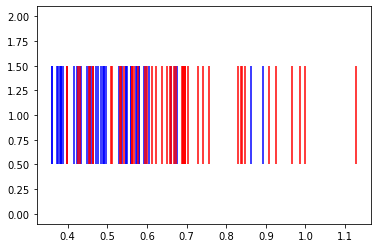

In [34]:
plt.figure()
plt.eventplot(out_0, orientation='horizontal', colors='b')
plt.eventplot(out_1, orientation='horizontal', colors='r')
plt.show()

In [35]:
out_0 = predict(model, criterion, val_images[-8:], batch_size=8)

In [36]:
out_1 = predict(model, criterion, val_images_1[-8:], batch_size=8)

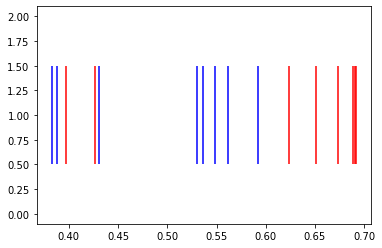

In [37]:
plt.figure()
plt.eventplot(out_0, orientation='horizontal', colors='b')
plt.eventplot(out_1, orientation='horizontal', colors='r')
plt.show()

Вывод: В среднем ошибка для атак выше, но четкого разделения не наблюдается.